# Visualizing an artist's network
### Chandler Haukap

Coming into this project I had no experience plotting. [Rebecca Weng's article](https://towardsdatascience.com/tutorial-network-visualization-basics-with-networkx-and-plotly-and-a-little-nlp-57c9bbb55bb9) on creating network graphs was a game changer!

## Import libraries and make sure spotify is working

In [1]:
import pandas as pd
import spotipy
import numpy as np
from spotipy.oauth2 import SpotifyOAuth
import networkx as nx
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objects as go
import json
%matplotlib inline

with open('../keys.json') as json_file:
    keys = json.load(json_file)
    
scope = "user-read-recently-played user-read-private user-read-email user-library-read user-library-modify playlist-modify-public"
sp = spotipy.Spotify(
  auth_manager=SpotifyOAuth(client_id=keys['spotify']['client_id'],
  client_secret=keys['spotify']['secret'],
  redirect_uri=keys['spotify']['redirect_uri'],
  scope=scope,
  open_browser=False)
)
sp.me()['display_name']

'Chandler'

### Lets pick an artist that has a few collaborations, but not too many.
But, lets be real, I was picking Lana Del Rey either way ;)

In [2]:
sp.search(q='artist:Lana Del Rey', type='artist')['artists']['items'][0]['id']

'00FQb4jTyendYWaN8pK0wa'

### Now we have an id for Lana. With that, we can view all of her albums

In [3]:
albums = sp.artist_albums('00FQb4jTyendYWaN8pK0wa')['items']
album_ids = []
for album in albums:
    print(album['name'])
    album_ids.append(album['id'])

Blue Banisters
Chemtrails Over The Country Club
Norman Fucking Rockwell!
Lust For Life
Lust For Life
Lust For Life
Honeymoon
Honeymoon
Honeymoon
Ultraviolence (Deluxe)
Ultraviolence
Ultraviolence (Deluxe)
Ultraviolence
Ultraviolence
Ultraviolence
Ultraviolence
Ultraviolence (Deluxe)
Ultraviolence
Ultraviolence - Audio Commentary
Born To Die - The Paradise Edition


### With the album ids available, we can iterate across them and pull all of the tracks.

In [4]:
all_tracks = []
for album in albums:
    all_tracks += sp.album_tracks(album['id'])['items']

### And finally, we can view all of the artists on the track. The first artist will be Lana of course, and the rest are her collaborators.

In [6]:
for track in all_tracks:
    for artist in track['artists']:
        if artist['name'] != 'Lana Del Rey':
            print(artist['name'])

Nikki Lane
Zella Day
Weyes Blood
The Weeknd
A$AP Rocky
Playboi Carti
A$AP Rocky
Stevie Nicks
Sean Ono Lennon
The Weeknd
A$AP Rocky
Playboi Carti
A$AP Rocky
Stevie Nicks
Sean Ono Lennon
The Weeknd
A$AP Rocky
Playboi Carti
A$AP Rocky
Stevie Nicks
Sean Ono Lennon
Photek


### Now that we have a proof of concept I'll wrap all of those loops into a single function.

In [7]:
def get_related_artists(artist_ids):
    artists = []
    for artist_id in artist_ids:
        artist = sp.artist(artist_id)
        all_tracks = []
        for album in sp.artist_albums(artist_id)['items']:
            all_tracks += sp.album_tracks(album['id'])['items']

        for track in all_tracks:
            for i in range(0, len(track['artists'])):
                if track['artists'][i]['id'] != artist['id']:
                    artists.append([
                        artist['name'], 
                        artist['id'], 
                        track['artists'][i]['name'], 
                        track['artists'][i]['id'],
                        track['name'],
                        track['id']
                    ])
                    
    return artists

### That's fairly complicated. Lets make sure it works.

In [8]:
artists = get_related_artists(['00FQb4jTyendYWaN8pK0wa'])
for artist in artists:
    print(f"{artist[0]}->{artist[2]}")

Lana Del Rey->Nikki Lane
Lana Del Rey->Zella Day
Lana Del Rey->Weyes Blood
Lana Del Rey->The Weeknd
Lana Del Rey->A$AP Rocky
Lana Del Rey->Playboi Carti
Lana Del Rey->A$AP Rocky
Lana Del Rey->Stevie Nicks
Lana Del Rey->Sean Ono Lennon
Lana Del Rey->The Weeknd
Lana Del Rey->A$AP Rocky
Lana Del Rey->Playboi Carti
Lana Del Rey->A$AP Rocky
Lana Del Rey->Stevie Nicks
Lana Del Rey->Sean Ono Lennon
Lana Del Rey->The Weeknd
Lana Del Rey->A$AP Rocky
Lana Del Rey->Playboi Carti
Lana Del Rey->A$AP Rocky
Lana Del Rey->Stevie Nicks
Lana Del Rey->Sean Ono Lennon
Lana Del Rey->Photek


### Looks good! However, this isn't much of a network. What about Lana's connections' connections? 
Here I have a choice. The cleanest code would be a recursive function that builds the network. However, recursion is slow. Stacking functions on top of functions puts a lot of strain on the python interpreter. On top of that, what if two branches of recursion contain the same artist? We could potentially duplicate a ton of work. Instead, lets write a dynamic program that does what we want.

In [9]:
def get_network(size, root_artist_id):
    network = get_related_artists([root_artist_id])
    next_index = 1
    last_index = 0
    
    for i in range(0, size-1):
        next_index = len(network)
        network += get_related_artists(np.unique(np.array([a[3] for a in network[last_index:]])))
        last_index = next_index

    return network

### And we'll test it out!

In [117]:
result = get_network(3, '00FQb4jTyendYWaN8pK0wa')
print(len(result))

74521


74,521 entries. That's waaay more than I expected. But, I bet there are some duplicates. I know for a fact that most music labels put out multiple versions of an album. Also, I know that the function I wrote doesn't account for two artists connecting on multiple songs. 

Therefore, we'll need to clean the data to see how many connections are actually present!

In [118]:
df = pd.DataFrame(result)
df.columns = [
    'primary_artist',
    'primary_artist_id',
    'featured_artist',
    'featured_artist_id',
    'track',
    'track_id'
]
df['unique_id'] = df.apply(lambda t: t.primary_artist_id + t.featured_artist_id, axis=1)
df['track'] = df.groupby('unique_id').track.transform(lambda q: "|".join(np.unique(np.array(q))))
df['track_id'] = df.groupby('unique_id').track_id.transform(lambda q: "|".join(np.unique(np.array(q))))

In [119]:
print(df.drop_duplicates(['unique_id']).shape)
df.drop_duplicates(['unique_id']).to_csv("lana_3.csv", index=False)

(24776, 7)


The first thing I did was convert the results into a Pandas DataFrame. Pandas gives me the ability to group entries and perform transformations on the groups. However, I need a column unique to each connection before I can create groups. 

That's why I start by combining the two artist ids. We only need one entry per combination, so we can remove the rest.

But, I wanted to do something fancier to handle the tracks. In order to retain all of the information I performed a transformation on the grouped tracks to join them using a "|" symbol. This will retain all of the information for artist combinations that collaborated on more than one song.

And finally, I removed duplicates with the `drop_duplicates` function. I saved the results to a CSV so I don't have to rerun all of those Spotify API calls.

### Anyways, we're down to 24,776 entries!

Now, lets make graphs!

In [22]:
depth_3 = pd.read_csv('lana_3.csv')

Here are the number of connections, but what about the number of nodes?

In [23]:
print(depth_3.featured_artist.unique().shape)

(10720,)


10,720 unique artists, a.k.a. nodes.

### A little more information

I want to make some cool visualizations. Right now, I have the nodes and edges for some graph visualizations, but I would like to add a few more dimensions. Here's my plan:

* Depth: The closeness to Lana. I want to express this in the visualization as the size of the nodes.
* Connectedness: The number of songs they have together: I want to express this as line (edge) thickness.

In [24]:
depth_3['songs'] = depth_3.track.map(lambda t: len(t.split("|")))
depth_3.songs.describe()

count    24776.000000
mean         1.990111
std          4.291406
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        132.000000
Name: songs, dtype: float64

132... that's a lot of songs. I might investigate that later, but for now I'm pushing forward with the visualization.

### Now the fun part- lets visualize the graph!

First, I ran into a problem with names like 'Joey Bada$$'. The HTML that I plan on generating needs the html code for '$'

In [25]:
depth_3.featured_artist = depth_3.featured_artist.map(lambda r: r.replace("$", "&#36;"))
depth_3.primary_artist = depth_3.primary_artist.map(lambda r: r.replace("$", "&#36;"))
depth_3.iloc[4].featured_artist

'A&#36;AP Rocky'

In [26]:
graph = nx.Graph()

In [31]:
def add_undirected_edge(graph, node_1, node_2, songs):
    graph.add_edge(
        node_1, 
        node_2, 
        songs=songs
    )
        
    graph.add_edge(
        node_2, 
        node_1, 
        songs=songs
    )

Adding the nodes and edges

In [34]:
_ = depth_3.apply(lambda e: graph.add_node(e.featured_artist), 
                  axis=1)
_ = depth_3.apply(lambda y: 
                  add_undirected_edge(
                      graph,
                      y.primary_artist, 
                      y.featured_artist, 
                      songs=y.songs
                  ), 
                  axis=1)

In [35]:
node_positions = nx.spring_layout(graph, scale=2)
node_positions['Lana Del Rey']

array([-0.12055352, -0.08662069])

In [36]:
def make_edge(x, y, text, width, depth):
    return  go.Scatter(x = x,
                       y = y,
                       line = dict(width = width,
                                   color = f'rgba(0, 0, {255 / depth}, 1)'),
                       hoverinfo = 'text',
                       text = ([text]),
                       mode = 'lines')

In [37]:
edge_trace = []
paths = dict(nx.all_pairs_shortest_path_length(graph))

for edge in graph.edges(data=True):
    char_1 = edge[0]
    char_2 = edge[1]

    x0, y0 = node_positions[char_1]
    x1, y1 = node_positions[char_2]

    text   = char_1 + '--' + char_2 + ': ' + '1'
    trace  = make_edge([x0, x1, None], [y0, y1, None], text, 2, 1)

    edge_trace.append(trace)

In [ ]:
node_trace = go.Scatter(x = [],
                        y = [],
                        text = [],
                        textposition = "top center",
                        textfont_size = 10,
                        mode = 'markers+text',
                        hoverinfo = 'none',
                        marker = dict(color = [],
                                      size  = [],
                                      line  = None),
                        textfont = dict(family= "sans serif",
                                        size  = 18,
                                        color = "Black")
                       )

for node, artist in depth_3.apply(lambda t: (t.featured_artist, t.primary_artist), axis=1):
    x, y = node_positions[node]
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])
    if node == 'Lana Del Rey':
        node_trace['marker']['color'] += tuple(['red'])
        node_trace['marker']['size'] += tuple([40])
    else:
        node_trace['marker']['color'] += tuple(['white'])
        node_trace['marker']['size'] += tuple([
            40 / (paths['Lana Del Rey'][node] if paths['Lana Del Rey'][node] is not 0 else 1)
        ])
    node_trace['text'] += tuple(['<b>' + node + '</b>'])

In [ ]:
layout = go.Layout(
    paper_bgcolor='rgba(73,73,73,1)',
    plot_bgcolor='rgba(0,100,0,0)',
    height=1080,
    width=1080
)
fig = go.Figure(layout = layout)

for trace in edge_trace:
    fig.add_trace(trace)

fig.add_trace(node_trace)

fig.update_layout(showlegend = False)
fig.update_xaxes(showticklabels = False, showgrid=False, zeroline=False)
fig.update_yaxes(showticklabels = False, showgrid=False, zeroline=False)

#fig.show()
py.plot(fig, filename='lana_test.html')

Notice that I commented out fig.show(). That's for good reason. The HTML file is insanely large. So large, in fact, that it's virtually unreadable.

### Since the depth 4 graph is so difficult to read, let's instead come up with some metrics.

I've run the get_network function with a depth of 1, 2, 3, and 4 why don't we see how the connection count is growing?

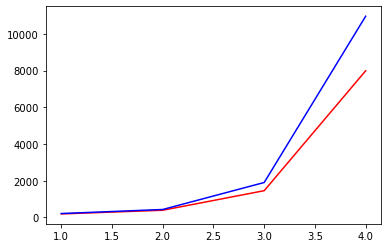

In [98]:
plt.plot(depth, people.values, 'r', depth, connections.values, 'b')


fig, ax = plt.subplots(nrows=1, ncols=1)
ax.bar(buckets.unique(), buckets[df.cat == 1].value_counts()[buckets.unique()], color='white')
ax.set_title("Pawpularity distribution for cats", color='white')
ax.set_xlabel("Pawpularity / 10")
ax.set_ylabel("Count")
ax.set_facecolor('#6504b5')
fig.patch.set_facecolor('#6504b5')
ax.spines['bottom'].set_color((.1, 0, 0, 0))
ax.spines['top'].set_color((.1, 0, 0, 0))
ax.spines['left'].set_color((.1, 0, 0, 0))
ax.spines['right'].set_color((.1, 0, 0, 0))
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
fig.savefig('cat_dist.png')
plt.show()

The number of connections seems to grow slightly faster than the number of people. This makes sense, because people added at new layers may have more than one connection. Also, I'm only looking at songs by the given artist featuring the connected artist and not the other way around. Therefore, it is possible that I could add an artist at depth 4 who has a song featuring Lana Del Rey. The connection wouldn't be present for depth=3, but it would appear for depth=4. This becomes clear if we look at Lana Del Rey's connection count at each depth.

In [107]:
print(len(graph_1['Lana Del Rey']))
print(len(graph_2['Lana Del Rey']))
print(len(graph_3['Lana Del Rey']))
print(len(graph_4['Lana Del Rey']))
print(graph_1['Lana Del Rey'])
print(graph_4['Lana Del Rey'])

9
10
11
12
{'Nikki Lane': {}, 'Zella Day': {}, 'Weyes Blood': {}, 'The Weeknd': {}, 'ASAP Rocky': {}, 'Playboi Carti': {}, 'Stevie Nicks': {}, 'Sean Ono Lennon': {}, 'Photek': {}}
{'Nikki Lane': {}, 'Zella Day': {}, 'Weyes Blood': {}, 'The Weeknd': {}, 'ASAP Rocky': {}, 'Playboi Carti': {}, 'Stevie Nicks': {}, 'Sean Ono Lennon': {}, 'Photek': {}, 'Kacey Musgraves': {}, 'Fred Armisen': {}, 'The Quebe Sisters': {}}


It suprises me that each layer adds one connection. I would expect that the probability of a new connection would decrease with each layer, but I suppose that is counterbalanced by the exponential growth of the nodes. Also, 

`Kacey Musgraves + Lana Del Rey >>>>>>>`

### But I digress. How about some network metrics?

In [128]:
got_graph_degree = pd.Series(list(dict(graph_4.degree()).values()))
got_graph_degree.describe()

count    7987.000000
mean        2.743709
std        10.610340
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max       267.000000
dtype: float64

In [137]:
sorted(graph_4.degree, key=lambda x: x[1], reverse=True)[0:5]

[('Sir Andrew Davis', 267),
 ('Shawn Pelton', 265),
 ('Ewan McGregor', 202),
 ('Hamza', 185),
 ('Ab-Soul', 170)]

Sir Andrew Davis? Makes sense.

Shawn Pelton? Okay.

Ewan McGregor?? What???

So it turns out Ewan McGregor is in a few musicals. Being in musicals means that he is featured alongside many, many artists. This is interesting to note- actors in musicals probably have many more musical connections (at least in terms of song credits).

In [95]:
paths = dict(nx.all_pairs_shortest_path_length(graph))

In [97]:
print(paths['Lana Del Rey'])

{'Lana Del Rey': 0, 'Sean Ono Lennon': 1, 'Photek': 1, 'Nikki Lane': 1, 'Stevie Nicks': 1, 'Weyes Blood': 1, 'Playboi Carti': 1, 'A&#36;AP Rocky': 1, 'The Weeknd': 1, 'Zella Day': 1, 'Miley Cyrus': 2, 'Krs.': 2, 'Ane Brun': 2, 'Of Monsters and Men': 2, 'Tom Petty and the Heartbreakers': 2, 'Red Coldhearted': 2, 'A&#36;AP Ferg': 2, 'Shelley FKA DRAM': 2, 'James Blake': 2, 'Elvis Presley': 2, 'T.I.': 2, 'Bobby Tucker Singers': 2, 'Dominic Cooper': 2, 'Eminem': 2, 'AURORA': 2, 'LeAnn Rimes': 2, '2 Chainz': 2, 'Golan': 2, 'YoungBoy Never Broke Again': 2, 'BENEE': 2, 'The Cranberries': 2, 'Nicki Minaj': 2, 'Boston Pops Orchestra': 2, 'Bree Runway': 2, 'Boulevards': 2, 'Shawn Colvin': 2, 'Kristina Murray': 2, 'Frank Sinatra': 2, 'Natalie Maines': 2, 'Leigh Nash': 2, 'Lil Mosey': 2, 'Surfaces': 2, 'SpaceGhostPurrp': 2, 'J Balvin': 2, 'Quality Control': 2, 'iann dior': 2, 'Dua Lipa': 2, 'Marshmello': 2, 'John Williams': 2, 'Ken Lane Singers': 2, 'Comethazine': 2, 'Emily Haines': 2, 'Peaches': 